In [ ]:
!pip install --upgrade fastai
!pip install --upgrade git+https://github.com/rbrtwlz/fastai_object_detection

  Cloning https://github.com/rbrtwlz/fastai_object_detection to /tmp/pip-req-build-tem00fe4
  Running command git clone -q https://github.com/rbrtwlz/fastai_object_detection /tmp/pip-req-build-tem00fe4
  Cloning https://github.com/bes-dev/mean_average_precision to /tmp/pip-install-ey90v938/mean-average-precision_b21b72e2f1ea45709a21c1f8490f8e01
  Running command git clone -q https://github.com/bes-dev/mean_average_precision /tmp/pip-install-ey90v938/mean-average-precision_b21b72e2f1ea45709a21c1f8490f8e01


In [ ]:
# default_exp callbacks

# Callbacks

> Converting batches to the required input of object detection models.

In [ ]:
#hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

import warnings
warnings.filterwarnings("ignore")

In [ ]:
#export 
from fastai.callback.all import *
from fastai.torch_basics import *
from fastai.torch_core import *

In [ ]:
# export 
# fix https://github.com/fastai/fastai/issues/3384

from fastai.vision.core import TensorBBox 
from fastai_object_detection.core import TensorBinMasks
from torch import Tensor

TensorMultiCategory.register_func(Tensor.__getitem__, TensorMultiCategory, TensorBBox, TensorBinMasks)
TensorMultiCategory.register_func(Tensor.__getitem__, TensorMultiCategory, TensorBBox, TensorBinMasks)


In [ ]:
#export
class ObjDetAdapter(Callback):
    """Callback to convert batches from fastai's dataloader to the 
    expected input of object detection and instance segmentation models"""
    
    def __init__(self, pad_idx=0): self.pad_idx = pad_idx
        
    def after_create(self):
        self.learn.save_xb = []
        self.learn.save_yb = []

    def before_batch(self):
        self.learn.save_xb = self.learn.xb
        self.learn.save_yb = self.learn.yb
        
        xb,yb = self.transform_batch(self.learn.xb[0], *self.learn.yb)
        self.learn.xb = [xb[0],yb[0]]
        self.learn.yb = []        
        
    def after_pred(self):
        
        # leave yb empty to skip loss calc
        loss = sum(loss for loss in self.learn.pred.values())
        self.learn.loss_grad = loss
        self.learn.loss = self.learn.loss_grad.clone()
        
    def after_loss(self):
        
        # set yb for recorder to log train loss
        self.learn.yb = self.learn.save_yb

        if not self.learn.training:
            # set model to eval to get predictions
            self.learn.model.eval()
            # transform batch to fasterrcnn´s expected input
            xb,yb = self.transform_batch(self.learn.save_xb[0], *self.learn.save_yb)
            # save predictions
            self.learn.pred = self.learn.model(xb[0])
            self.learn.yb = yb
            self.learn.model.train()
            

    def after_batch(self):
        self.learn.model.train()

        
    def before_validate(self):
        # set model to train to get valid loss
        self.learn.model.train()  

        
    def transform_batch(self,x1,*yb):
        yb = [*yb]
        # check if with or without mask
        with_mask = len(yb) == 3

        bs,c,h,w = x1.shape
        dev = x1.device

        y={}
        keys = "masks boxes labels".split() if with_mask else "boxes labels".split()
        for i,k in enumerate(keys):
            y[k] = [e for e in yb[i]]
            
        y = [dict(zip(y,t)) for t in zip(*y.values())] # dict of lists to list of dicts

        for d in y:
            # remove padding
            filt = d["labels"]!=self.pad_idx
            for k in keys:
                d[k] = d[k][filt]
                
            # remove empty bboxes
            filt = (d["boxes"][:,0]-d["boxes"][:,2])*(d["boxes"][:,1]-d["boxes"][:,3])!=0
            #filt = torch.eq(d["boxes"], tensor([[0.,0.,0.,0.]], device=dev)).all(dim=1)
            for k in keys:
                d[k] = d[k][filt]
        
            # scale bboxes back
            d["boxes"] = (d["boxes"]+1.)*tensor([w,h,w,h], device=dev)*0.5

            if with_mask:
                # filter out objects with empty masks
                filt = d["masks"].sum(dim=-1).sum(dim=-1)==0 
                for k in keys:
                    d[k] = d[k][~filt]
    
        return [x1],[y] # xb,yb

In [ ]:
from fastai_object_detection.dataloaders import ObjectDetectionDataLoaders
from fastai_object_detection.datasets import CocoData
from fastai.vision.all import *

path,df = CocoData.get_path_df("ds-cats-dogs")
dls = ObjectDetectionDataLoaders.from_df(df, bs=9, item_tfms=[Resize(600)])
b = dls.one_batch()

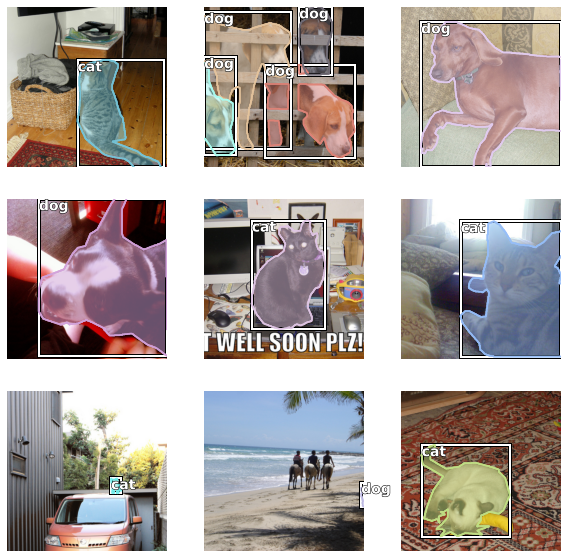

In [ ]:
dls.show_batch(b, figsize=(10,10))

In [ ]:
[(t.shape, type(t)) for t in b]

[(torch.Size([9, 3, 600, 600]), fastai.torch_core.TensorImage),
 (torch.Size([9, 4, 600, 600]), fastai.torch_core.TensorMask),
 (torch.Size([9, 4, 4]), fastai.vision.core.TensorBBox),
 (torch.Size([9, 4]), fastai.torch_core.TensorMultiCategory)]

In [ ]:
adapter = ObjDetAdapter()
xb,yb = adapter.transform_batch(b[0], *b[1:])

In [ ]:
num_objs = [t.item() for t in b[1].sum((-2,-1)).gt(0).sum(1)]
num_objs

In [ ]:
for i,d in enumerate(yb[0]):
    n1 = len(d["labels"])
    n2,_ = d["boxes"].shape
    n3,_,_ = d["masks"].shape
    test_eq(n1,n2)
    test_eq(n2,n3)
    test_eq(n3,num_objs[i])
    
    bbs = d["boxes"]
    area = (bbs[:,2]-bbs[:,0])*(bbs[:,3]-bbs[:,1])
    test_eq((area<=0).any(), False)
    


In [ ]:
for i,b in enumerate(dls.train):
    xb,yb = adapter.transform_batch(b[0], *b[1:])
    num_objs = [t.item() for t in b[1].sum((-2,-1)).gt(0).sum(1)]
    for i,d in enumerate(yb[0]):
        n1 = len(d["labels"])
        n2,_ = d["boxes"].shape
        n3,_,_ = d["masks"].shape
        test_eq(n1,n2)
        test_eq(n2,n3)
        test_eq(n1,num_objs[i])
        bbs = d["boxes"]
        area = (bbs[:,2]-bbs[:,0])*(bbs[:,3]-bbs[:,1])
        test_eq((area<=0).any(), False)
